# Impact Reporting

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import PartialDependenceDisplay
import statsmodels.api as sm
import dash, dash_core_components as dcc, dash_html_components as html
import plotly.express as px

X_train = pd.read_csv("../data/processed/X_train_unprocessed.csv")
y_train = pd.read_csv("../data/processed/y_train.csv")
X_test = pd.read_csv("../data/processed/X_test_unprocessed.csv")
y_test = pd.read_csv("../data/processed/y_test.csv")
metadata = pd.read_csv("../data/raw/yield_tables_meta.csv", sep=";")
cleaned_data = pd.read_csv("../data/interim/cleaned_data.csv")

target_variable = "volume_per_ha"

# Initialize two models - linear regression and extra trees - selected them because they performed best in the last two notebooks
models = {
    "Linear": LinearRegression(),
    "ExtraTrees": ExtraTreesRegressor(n_estimators=100, max_depth=20, random_state=42),
}
for name, model in models.items():
    model.fit(X_train, y_train[target_variable])

    score = cross_val_score(model, X_train, y_train[target_variable], cv=5).mean()
    print(f"{name}: {score:.3f}")

Linear: 0.880
ExtraTrees: 0.994


## Prediction vs Actual Scatter

💡 Concept: Residual = actual − predicted. Plotting residuals uncovers patterns your model missed.

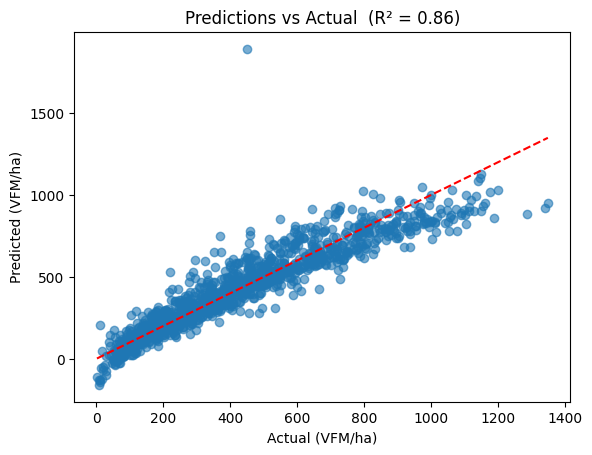

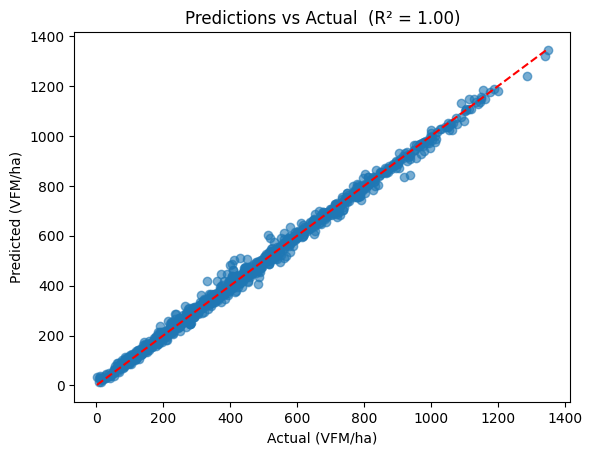

In [40]:
for name, model in models.items():
    y_pred = model.predict(X_test)
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
    plt.xlabel("Actual (VFM/ha)")
    plt.ylabel("Predicted (VFM/ha)")
    plt.title(f"Predictions vs Actual  (R² = {r2_score(y_test,y_pred):.2f})")
    plt.show()

## Feature Importance Bars

Three Common Methods:

- |β| from standardised linear coefficients
- Permutation importance (model-agnostic)
- Tree-based feature_importances_

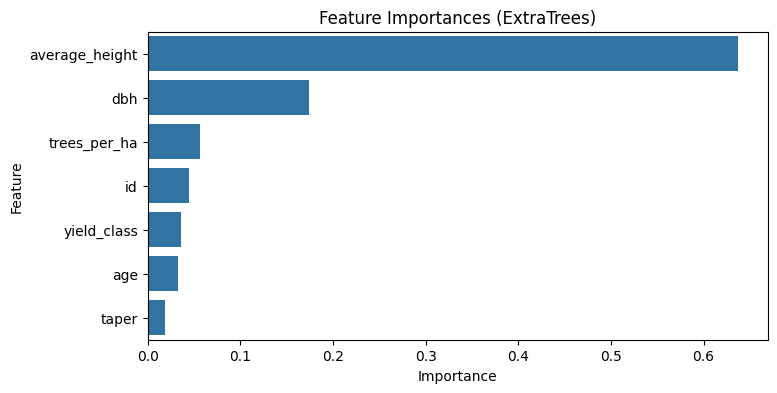

In [41]:
impotences = models["ExtraTrees"].feature_importances_
# Sort features by importance
sorted_idx = impotences.argsort()[::-1]
features = features[sorted_idx]
impotences = impotences[sorted_idx]
plt.figure(figsize=(8, 4))
sns.barplot(x=impotences, y=features)
plt.title("Feature Importances (ExtraTrees)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

## Partial-Dependence & ICE Curves

💡 Concept: Partial dependence plots (PDP) shows average effect; Individual conditional expectation (ICE) shows each observation’s trajectory—crucial for detecting heterogeneous relationships.

Text(0.5, 1.0, 'ICE')

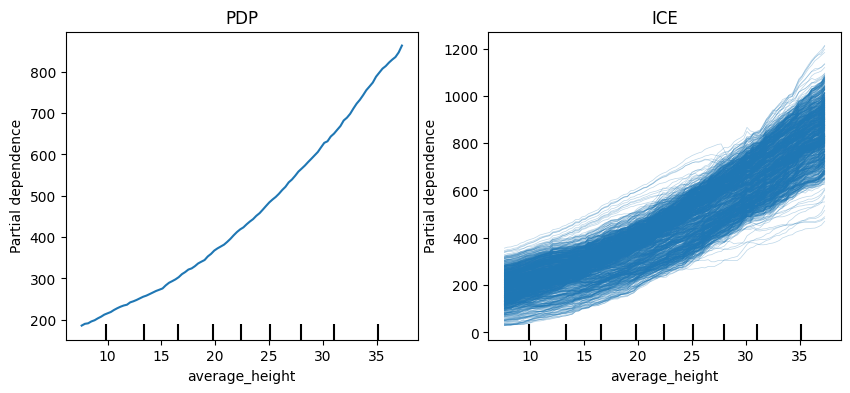

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
PartialDependenceDisplay.from_estimator(
    models["ExtraTrees"], X_test, ["average_height"], ax=ax[0]
)
PartialDependenceDisplay.from_estimator(
    models["ExtraTrees"], X_test, ["average_height"], kind="individual", ax=ax[1]
)
ax[0].set_title("PDP")
ax[1].set_title("ICE")

## Confidence & Prediction Intervals

💡 Concept: Showing a line and its uncertainty band is more honest and useful than a naked point estimate.

**Confidence interval (CI):** We’re 95% sure the average house price for 3-bed homes is between X and Y.

**Prediction interval (PI):** A single 3-bed house could sell anywhere between A and B (wider – covers individual noise).


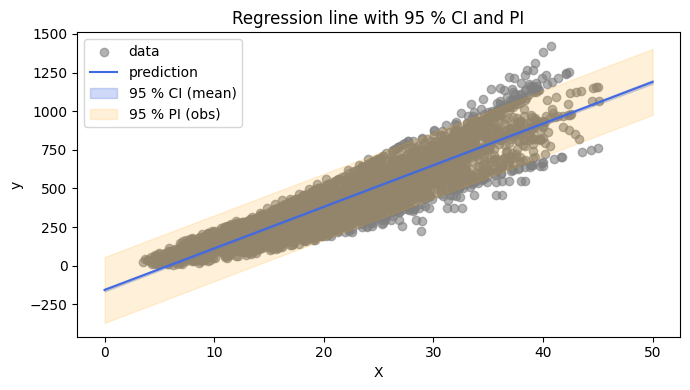

   mean_ci_lower  mean_ci_upper
0    -167.388759    -147.263552
1    -166.477491    -146.377880
2    -165.566226    -145.492206
3    -164.654962    -144.606529
4    -163.743702    -143.720849 

   obs_ci_lower  obs_ci_upper
0   -370.427257     55.774945
1   -369.528183     56.672811
2   -368.629110     57.570678
3   -367.730037     58.468546
4   -366.830966     59.366415


In [54]:
# 1) Toy data ─ replace with your own ------------------------------------
X = X_train["average_height"]
y = y_train["volume_per_ha"]

# 2) Fit an OLS model ----------------------------------------------------
X_ = sm.add_constant(X)  # adds β0 (intercept) column
model = sm.OLS(y, X_).fit()

# 3) New points where we want intervals ---------------------------------
x_new = np.linspace(0, 50, 1500)
X_new = sm.add_constant(x_new)

pred = model.get_prediction(X_new)
pred_df = pred.summary_frame(alpha=0.05)  # 95 % intervals

# 4) Plot: line, CI ribbon, PI ribbon -----------------------------------
plt.figure(figsize=(7, 4))
plt.scatter(X, y, color="grey", alpha=0.6, label="data")
plt.plot(x_new, pred_df["mean"], color="royalblue", label="prediction")

# 95 % CI for the *mean* prediction
plt.fill_between(
    x_new,
    pred_df["mean_ci_lower"],
    pred_df["mean_ci_upper"],
    color="royalblue",
    alpha=0.25,
    label="95 % CI (mean)",
)

# 95 % PI for a *single* future observation
plt.fill_between(
    x_new,
    pred_df["obs_ci_lower"],
    pred_df["obs_ci_upper"],
    color="orange",
    alpha=0.15,
    label="95 % PI (obs)",
)

plt.xlabel("X")
plt.ylabel("y")
plt.title("Regression line with 95 % CI and PI")
plt.legend()
plt.tight_layout()
plt.show()

# 5) If you just need the numbers ---------------------------------------
ci = pred_df[["mean_ci_lower", "mean_ci_upper"]]
pi = pred_df[["obs_ci_lower", "obs_ci_upper"]]
print(ci.head(), "\n")
print(pi.head())

In [76]:
app = dash.Dash(__name__)

y_pred_linear = models["Linear"].predict(X_train)
y_pred_tree = models["ExtraTrees"].predict(X_train)

app.layout = html.Div(
    [
        dcc.Graph(
            figure=px.scatter(
                x=y_train[target_variable],
                y=y_pred_linear,
                title="Actuals vs Predictions (Linear)",
                labels={"x": "Actuals", "y": "Predictions"},
            )
        ),
        dcc.Graph(
            figure=px.scatter(
                x=y_train[target_variable],
                y=y_pred_tree,
                title="Actuals vs Predictions (Extra Trees)",
                labels={"x": "Actuals", "y": "Predictions"},
            )
        )
    ]
)

app.run_server(debug=True)